# Minimize makespan

In this notebook, we evaluate the impact of splitting larger optimization problems into smaller sub-problems on policy runtime and quality of solution for minimize makespan policies.

## Import statements

In [1]:
import sys; sys.path.append("../../..")
from job_id_pair import JobIdPair
import utils
from plotting_utils import plot_runtimes, plot_effective_throughput_ratios

import copy
import numpy as np
import random
import time

np.set_printoptions(precision=3, suppress=True)

Matplotlib is building the font cache; this may take a moment.


## Harness that runs a policy with the passed-in number of sub-clusters

In [2]:
def create_problem_instance(num_jobs, cluster_spec,
                            policy_name,
                            seed,
                            introduce_skew=False):
    oracle_throughputs = utils.read_all_throughputs_json_v2("../../../simulation_throughputs.json")
    rng = random.Random()
    rng.seed(seed)
    jobs = {}
    throughputs = {}
    scale_factors = {}
    num_steps_remaining = {}
    for i in range(num_jobs):
        job_id = JobIdPair(i, None)
        job = utils.generate_job(throughputs=oracle_throughputs,
                                 rng=rng, job_id=job_id)
        jobs[job_id[0]] = job
        job_type_key = (job.job_type, job.scale_factor)
        throughputs[job_id] = {}
        for worker_type in cluster_spec:
            throughputs[job_id][worker_type] = \
                oracle_throughputs[worker_type][job_type_key]['null']
        scale_factors[job_id] = 1
        num_steps_remaining[job_id] = job.total_steps
    if 'pack' in policy_name:
        for i in range(num_jobs):
            job_type_key = (jobs[i].job_type, jobs[i].scale_factor)
            for j in range(num_jobs):
                if i < j and jobs[i].scale_factor == jobs[j].scale_factor:
                    other_job_type_key = \
                        (jobs[j].job_type, jobs[j].scale_factor)
                    throughputs[JobIdPair(i, j)] = {}
                    for worker_type in cluster_spec:
                        throughputs[JobIdPair(i, j)][worker_type] = \
                            oracle_throughputs[worker_type][job_type_key][other_job_type_key]
    return throughputs, scale_factors, num_steps_remaining

In [3]:
def harness(policy, throughputs, scale_factors, num_steps_remaining, cluster_spec, num_sub_clusters=1,
            random_cluster_assignment=False):
    start_time = time.time()
    sub_cluster_throughputs = []
    sub_cluster_scale_factors = []
    sub_cluster_num_steps_remaining = []
    job_to_sub_cluster_assignment = {}
    job_ids = []
    for job_id in throughputs:
        if not job_id.is_pair():
            job_ids.append(job_id)
    for i, job_id in enumerate(job_ids):
        if random_cluster_assignment:
            job_to_sub_cluster_assignment[job_id[0]] = random.randint(0, num_sub_clusters-1)
        else:
            job_to_sub_cluster_assignment[job_id[0]] = job_id[0] % num_sub_clusters
    for i in range(num_sub_clusters):
        sub_cluster_throughputs.append({})
        sub_cluster_scale_factors.append({})
        sub_cluster_num_steps_remaining.append({})
        for job_id in throughputs:
            if (job_to_sub_cluster_assignment[job_id[0]] == i) and (
                 not job_id.is_pair() or (job_to_sub_cluster_assignment[job_id[1]] == i)):
                sub_cluster_throughputs[-1][job_id] = copy.copy(throughputs[job_id])
                if not job_id.is_pair():
                    sub_cluster_scale_factors[-1][job_id] = scale_factors[job_id]
                    sub_cluster_num_steps_remaining[-1][job_id] = num_steps_remaining[job_id]
    sub_cluster_cluster_spec = {worker_type: cluster_spec[worker_type] // num_sub_clusters
                                for worker_type in cluster_spec}
    setup_time = time.time() - start_time
    full_allocation = {}
    computation_times = []
    for i in range(num_sub_clusters):
        start_time = time.time()
        sub_cluster_allocation = policy.get_allocation(sub_cluster_throughputs[i], sub_cluster_scale_factors[i],
                                                       sub_cluster_num_steps_remaining[i], sub_cluster_cluster_spec)
        for job_id in sub_cluster_allocation:
            full_allocation[job_id] = sub_cluster_allocation[job_id]
        computation_times.append(time.time() - start_time)
    return full_allocation, setup_time + max(computation_times)

## Runtimes

In [4]:
def get_runtimes(policy_name, all_num_jobs, introduce_skew=False,
                 random_cluster_assignment=False):
    data = {
        'policy': [],
        'num_jobs': [],
        'runtimes': []
    }
    for num_jobs in all_num_jobs:
        cluster_spec = {
            'v100': max(num_jobs // 4, 1),
            'p100': max(num_jobs // 4, 1),
            'k80': max(num_jobs // 4, 1),
        }
        for i in range(3):
            throughputs, scale_factors, num_steps_remaining = \
                create_problem_instance(num_jobs, cluster_spec,
                                        policy_name, seed=i,
                                        introduce_skew=introduce_skew)
            policy = utils.get_policy(policy_name, solver='ECOS')
            _, vanilla_runtime = harness(policy, throughputs,
                                         scale_factors, num_steps_remaining, cluster_spec)
            _, four_sub_clusters_runtime = harness(policy, throughputs,
                                                   scale_factors, num_steps_remaining, cluster_spec,
                                                   num_sub_clusters=4,
                                                   random_cluster_assignment=random_cluster_assignment)
            _, sixteen_sub_clusters_runtime = harness(policy, throughputs,
                                                      scale_factors, num_steps_remaining, cluster_spec,
                                                      num_sub_clusters=16,
                                                      random_cluster_assignment=random_cluster_assignment)
            for (policy_label, runtime) in zip(['Vanilla', '4 sub-clusters', '16 sub-clusters'],
                                               [vanilla_runtime, four_sub_clusters_runtime,
                                                sixteen_sub_clusters_runtime]):
                data['policy'].append(policy_label)
                data['num_jobs'].append(num_jobs)
                data['runtimes'].append(runtime)
    return data

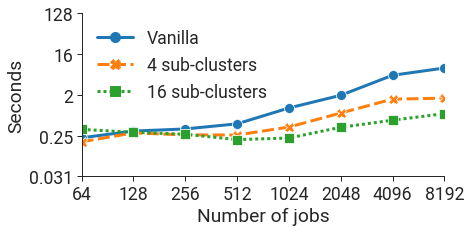

In [5]:
all_num_jobs = [64, 128, 256, 512, 1024, 2048, 4096, 8192]
xticks = [64, 128, 256, 512, 1024, 2048, 4096, 8192]
yticks = [2**-5, 2**-2, 2**1, 2**4, 2**7]
yticklabels = [0.031, 0.25, 2, 16, 128]
plot_runtimes(get_runtimes('min_total_duration_perf',
                           all_num_jobs=all_num_jobs,
                           introduce_skew=True,
                           random_cluster_assignment=True),
              xticks=xticks, yticks=yticks,
              yticklabels=yticklabels,
              output_filename="runtimes/min_total_duration_perf.pdf")

## Effective throughput ratios

In [6]:
def get_effective_throughput_ratios(policy_name, num_jobs, introduce_skew=False,
                                    random_cluster_assignment=False):
    cluster_spec = {
        'v100': max(num_jobs // 4, 1),
        'p100': max(num_jobs // 4, 1),
        'k80': max(num_jobs // 4, 1),
    }
    random.seed(42)
    throughputs, scale_factors, num_steps_remaining = \
        create_problem_instance(num_jobs, cluster_spec,
                                policy_name, seed=0,
                                introduce_skew=introduce_skew)
    policy = utils.get_policy(policy_name, solver='ECOS')
    vanilla_allocation, _ = harness(policy, throughputs,
                                    scale_factors, num_steps_remaining, cluster_spec)
    four_sub_clusters_allocation, _ = harness(policy, throughputs,
                                              scale_factors, num_steps_remaining, cluster_spec,
                                              num_sub_clusters=4,
                                              random_cluster_assignment=random_cluster_assignment)
    sixteen_sub_clusters_allocation, _ = harness(policy, throughputs,
                                                 scale_factors, num_steps_remaining, cluster_spec,
                                                 num_sub_clusters=16,
                                                 random_cluster_assignment=random_cluster_assignment)
    all_effective_throughputs = []
    for allocation in [vanilla_allocation, four_sub_clusters_allocation,
                       sixteen_sub_clusters_allocation]:
        effective_throughputs = {}
        for job_id in allocation:
            for single_job_id in job_id.singletons():
                if single_job_id not in effective_throughputs:
                    effective_throughputs[single_job_id] = 0.0
            for worker_type in allocation[job_id]:
                if job_id.is_pair():
                    for i, single_job_id in enumerate(job_id.singletons()):
                        effective_throughputs[single_job_id] += (
                           allocation[job_id][worker_type] *
                           throughputs[job_id][worker_type][i]
                        )
                else:
                    effective_throughputs[job_id] += (
                        allocation[job_id][worker_type] *
                        throughputs[job_id][worker_type])
        all_effective_throughputs.append(effective_throughputs)
    return all_effective_throughputs

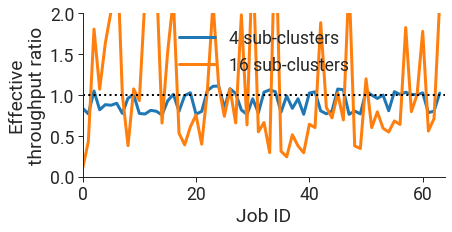

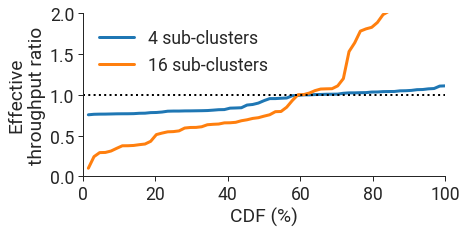

In [7]:
plot_effective_throughput_ratios(
    get_effective_throughput_ratios('min_total_duration_perf', 64,
                                    introduce_skew=True,
                                    random_cluster_assignment=True),
    output_filename="effective_throughput_ratios/min_total_duration_perf_skewed_random.pdf")
plot_effective_throughput_ratios(
    get_effective_throughput_ratios('min_total_duration_perf', 64,
                                    introduce_skew=True,
                                    random_cluster_assignment=True),
    cdf=True,
    output_filename="effective_throughput_ratios/min_total_duration_perf_skewed_random_cdf.pdf")